In [1]:
from load_dataset.artgraph import ArtGraph
from utils.MultiTaskLinkSplitter import MultiTaskLinkSplitter
from utils.dataset import TrainingDataSet, TestDataSet
from utils.EarlyStopping import EarlyStopping
from multi_task_model import MultiTaskClassificationModel, NewMultiTaskClassificationModel
from torch import nn
from utils.training_utils import fine_tune, test as test_func, compute_topk, plot_confusion_matrix
from torch.utils.data import DataLoader
from torch import optim
import torch
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
root = 'artgraph2bestemotions'
data_path = 'data_full_labels.csv'
root_dataset = 'common_dataset'

In [4]:
data = ArtGraph(root = root, preprocess='constant', features = 'vit', fine_tuning = True)[0]
data

Processing...
Done!


HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [5]:
train = torch.load(f'{root_dataset}/train_data.pt')
val = torch.load(f'{root_dataset}/val_set.pt')
test = torch.load(f'{root_dataset}/test_set.pt')

In [6]:
#loading data with labels
data_labels = pd.read_csv(data_path)
data_labels.index = data_labels.artwork
data_labels['style'] -= 1
data_labels

,artwork,style,genre,emotion
artwork,,,,
81418,81418,0,4,4
28493,28493,2,9,5
28421,28421,2,3,8
28393,28393,2,9,8
28380,28380,2,9,7
...,...,...,...,...
71300,71300,9,6,8
68290,68290,22,6,8
68567,68567,22,6,8


In [8]:
train_dataset = TrainingDataSet(graph = train, data_labels = data_labels)

In [9]:
val_dataset = TestDataSet(graph = train, x_test = val, data_labels = data_labels)

In [10]:
test_dataset = TestDataSet(graph = train, x_test = test, data_labels = data_labels)

Test per vedere se va bene il modello pre-trained

In [11]:
device = torch.device('cuda:0')
genre_model = torch.load('genre.pt').to(device)
genre_model

ModelClassification(
  (encoder): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (decoder): Head(
    (head): Sequential(
      (0): Linear(in_features=2432, out_features=1216, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1216, out_features=608, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=608, out_features=304, bias=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=304, out_features=152, bias=True)
      (10): LeakyReLU(negative_slope=0.1, inplace=True)
      (11): Dropout(p=0.25, inplace=False)
      (12): Linear(in_features=152, out_features=18, bias=True)
    )
  )
)

In [12]:
from tqdm import tqdm
device = torch.device('cuda:0')
train = train.to(device)

test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, drop_last = False)
with torch.no_grad():
    running_corrects = 0 
    for _, images, (style_labels, genre_labels, emotion_labels) in tqdm(test_loader):
        images = images.to(device, non_blocking = True)
        genre_labels = genre_labels.to(device, non_blocking = True)
        genre_pred = genre_model(train.x_dict, train.edge_index_dict, images)
        running_corrects += torch.sum(torch.max(genre_pred, 1)[1] == genre_labels)
    print(f'Acc: {running_corrects/len(test_loader.dataset)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:37<00:00,  1.35it/s]

Acc: 0.8140996694564819


## INSTANTIATING MODEL

In [13]:
device = torch.device('cuda:0')
style_encoder = torch.load('best_model_style_single_task.pt').encoder
genre_encoder = torch.load('best_model_genre_single_task.pt').encoder
emotion_encoder = torch.load('best_model_emotion_single_task.pt').encoder
model = NewMultiTaskClassificationModel(data = data, hidden_channels=None, head_num_layers=5,
                                        encoders = (style_encoder, genre_encoder, emotion_encoder)).to(device)

In [14]:
model

NewMultiTaskClassificationModel(
  (encoder_style): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_genre): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_emotion): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=7680, out_features=3840, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=3840, out_features=1920, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1920, out_features=960, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=960, out_features=480, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
  )
  (

In [15]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder_style(train.x_dict, train.edge_index_dict)
    model.encoder_genre(train.x_dict, train.edge_index_dict)
    model.encoder_emotion(train.x_dict, train.edge_index_dict)

In [16]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_new_multitask_model.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)


Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:21<00:00, 19.36it/s]


train Loss: 1.7753 Style Acc: 0.3233
            Genre Acc: 0.5517
            Emotion Acc: 0.3834


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.30it/s]


val Loss: 1.5049 Style Acc: 0.4144
            Genre Acc: 0.6455
            Emotion Acc: 0.4130
Validation loss decreased. Saving model...
Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.74it/s]


train Loss: 1.4384 Style Acc: 0.4464
            Genre Acc: 0.6691
            Emotion Acc: 0.4093


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.61it/s]


val Loss: 1.3681 Style Acc: 0.4856
            Genre Acc: 0.6944
            Emotion Acc: 0.4165
Validation loss decreased. Saving model...
Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.57it/s]


train Loss: 1.3726 Style Acc: 0.4825
            Genre Acc: 0.6830
            Emotion Acc: 0.4219


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.84it/s]


val Loss: 1.3314 Style Acc: 0.5015
            Genre Acc: 0.6933
            Emotion Acc: 0.4335
Validation loss decreased. Saving model...
Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.39it/s]


train Loss: 1.3281 Style Acc: 0.5087
            Genre Acc: 0.6960
            Emotion Acc: 0.4263


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.47it/s]


val Loss: 1.3093 Style Acc: 0.5242
            Genre Acc: 0.6924
            Emotion Acc: 0.4349
Validation loss decreased. Saving model...
Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.70it/s]


train Loss: 1.2975 Style Acc: 0.5244
            Genre Acc: 0.7023
            Emotion Acc: 0.4295


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 54.91it/s]


val Loss: 1.2915 Style Acc: 0.5198
            Genre Acc: 0.7059
            Emotion Acc: 0.4401
Validation loss decreased. Saving model...
Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.55it/s]


train Loss: 1.2740 Style Acc: 0.5361
            Genre Acc: 0.7089
            Emotion Acc: 0.4323


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.61it/s]


val Loss: 1.2954 Style Acc: 0.5362
            Genre Acc: 0.6909
            Emotion Acc: 0.4363
EarlyStopping counter: 1 out of 5
Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.56it/s]


train Loss: 1.2539 Style Acc: 0.5510
            Genre Acc: 0.7116
            Emotion Acc: 0.4378


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.49it/s]


val Loss: 1.2621 Style Acc: 0.5473
            Genre Acc: 0.7027
            Emotion Acc: 0.4410
Validation loss decreased. Saving model...
Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.59it/s]


train Loss: 1.2366 Style Acc: 0.5582
            Genre Acc: 0.7158
            Emotion Acc: 0.4398


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.61it/s]


val Loss: 1.2538 Style Acc: 0.5456
            Genre Acc: 0.7166
            Emotion Acc: 0.4349
Validation loss decreased. Saving model...
Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.60it/s]


train Loss: 1.2183 Style Acc: 0.5665
            Genre Acc: 0.7215
            Emotion Acc: 0.4400


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.19it/s]


val Loss: 1.2523 Style Acc: 0.5547
            Genre Acc: 0.7129
            Emotion Acc: 0.4294
Validation loss decreased. Saving model...
Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.55it/s]


train Loss: 1.2042 Style Acc: 0.5778
            Genre Acc: 0.7266
            Emotion Acc: 0.4445


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.42it/s]


val Loss: 1.2320 Style Acc: 0.5636
            Genre Acc: 0.7161
            Emotion Acc: 0.4358
Validation loss decreased. Saving model...
Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.52it/s]


train Loss: 1.1895 Style Acc: 0.5873
            Genre Acc: 0.7274
            Emotion Acc: 0.4479


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.74it/s]


val Loss: 1.2290 Style Acc: 0.5764
            Genre Acc: 0.7151
            Emotion Acc: 0.4384
Validation loss decreased. Saving model...
Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.38it/s]


train Loss: 1.1745 Style Acc: 0.5910
            Genre Acc: 0.7341
            Emotion Acc: 0.4463


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.55it/s]


val Loss: 1.2274 Style Acc: 0.5581
            Genre Acc: 0.7252
            Emotion Acc: 0.4346
Validation loss decreased. Saving model...
Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.60it/s]


train Loss: 1.1618 Style Acc: 0.6005
            Genre Acc: 0.7383
            Emotion Acc: 0.4479


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.36it/s]


val Loss: 1.2235 Style Acc: 0.5806
            Genre Acc: 0.7209
            Emotion Acc: 0.4427
Validation loss decreased. Saving model...
Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.64it/s]


train Loss: 1.1492 Style Acc: 0.6062
            Genre Acc: 0.7408
            Emotion Acc: 0.4506


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.57it/s]


val Loss: 1.2097 Style Acc: 0.5849
            Genre Acc: 0.7286
            Emotion Acc: 0.4467
Validation loss decreased. Saving model...
Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.59it/s]


train Loss: 1.1361 Style Acc: 0.6147
            Genre Acc: 0.7459
            Emotion Acc: 0.4522


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.80it/s]


val Loss: 1.1949 Style Acc: 0.5869
            Genre Acc: 0.7312
            Emotion Acc: 0.4421
Validation loss decreased. Saving model...
Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.60it/s]


train Loss: 1.1221 Style Acc: 0.6194
            Genre Acc: 0.7508
            Emotion Acc: 0.4515


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.81it/s]


val Loss: 1.2130 Style Acc: 0.5872
            Genre Acc: 0.7269
            Emotion Acc: 0.4361
EarlyStopping counter: 1 out of 5
Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.61it/s]


train Loss: 1.1111 Style Acc: 0.6256
            Genre Acc: 0.7546
            Emotion Acc: 0.4536


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.55it/s]


val Loss: 1.1814 Style Acc: 0.5941
            Genre Acc: 0.7335
            Emotion Acc: 0.4422
Validation loss decreased. Saving model...
Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.38it/s]


train Loss: 1.0959 Style Acc: 0.6315
            Genre Acc: 0.7574
            Emotion Acc: 0.4566


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.72it/s]


val Loss: 1.1749 Style Acc: 0.6011
            Genre Acc: 0.7333
            Emotion Acc: 0.4436
Validation loss decreased. Saving model...
Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.55it/s]


train Loss: 1.0849 Style Acc: 0.6383
            Genre Acc: 0.7607
            Emotion Acc: 0.4581


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 53.43it/s]


val Loss: 1.1792 Style Acc: 0.6046
            Genre Acc: 0.7289
            Emotion Acc: 0.4418
EarlyStopping counter: 1 out of 5
Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.56it/s]


train Loss: 1.0686 Style Acc: 0.6482
            Genre Acc: 0.7654
            Emotion Acc: 0.4599


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 54.79it/s]


val Loss: 1.1730 Style Acc: 0.6039
            Genre Acc: 0.7376
            Emotion Acc: 0.4429
Validation loss decreased. Saving model...
Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.55it/s]


train Loss: 1.0580 Style Acc: 0.6531
            Genre Acc: 0.7677
            Emotion Acc: 0.4633


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.62it/s]


val Loss: 1.1731 Style Acc: 0.6005
            Genre Acc: 0.7339
            Emotion Acc: 0.4433
EarlyStopping counter: 1 out of 5
Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.52it/s]


train Loss: 1.0427 Style Acc: 0.6598
            Genre Acc: 0.7720
            Emotion Acc: 0.4647


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.68it/s]


val Loss: 1.1670 Style Acc: 0.6118
            Genre Acc: 0.7331
            Emotion Acc: 0.4433
Validation loss decreased. Saving model...
Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.52it/s]


train Loss: 1.0333 Style Acc: 0.6659
            Genre Acc: 0.7762
            Emotion Acc: 0.4640


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.68it/s]


val Loss: 1.1578 Style Acc: 0.6121
            Genre Acc: 0.7423
            Emotion Acc: 0.4430
Validation loss decreased. Saving model...
Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.36it/s]


train Loss: 1.0169 Style Acc: 0.6736
            Genre Acc: 0.7808
            Emotion Acc: 0.4683


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.62it/s]


val Loss: 1.1704 Style Acc: 0.6066
            Genre Acc: 0.7353
            Emotion Acc: 0.4435
EarlyStopping counter: 1 out of 5
Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.46it/s]


train Loss: 1.0030 Style Acc: 0.6816
            Genre Acc: 0.7848
            Emotion Acc: 0.4685


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.00it/s]


val Loss: 1.1511 Style Acc: 0.6215
            Genre Acc: 0.7413
            Emotion Acc: 0.4458
Validation loss decreased. Saving model...
Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.50it/s]


train Loss: 0.9892 Style Acc: 0.6881
            Genre Acc: 0.7882
            Emotion Acc: 0.4714


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.18it/s]


val Loss: 1.1602 Style Acc: 0.6132
            Genre Acc: 0.7374
            Emotion Acc: 0.4441
EarlyStopping counter: 1 out of 5
Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.58it/s]


train Loss: 0.9753 Style Acc: 0.6953
            Genre Acc: 0.7918
            Emotion Acc: 0.4733


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.05it/s]


val Loss: 1.1546 Style Acc: 0.6222
            Genre Acc: 0.7371
            Emotion Acc: 0.4444
Epoch 00027: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 2 out of 5
Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.52it/s]


train Loss: 0.9288 Style Acc: 0.7181
            Genre Acc: 0.8084
            Emotion Acc: 0.4797


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.25it/s]


val Loss: 1.1471 Style Acc: 0.6172
            Genre Acc: 0.7410
            Emotion Acc: 0.4478
Validation loss decreased. Saving model...
Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.54it/s]


train Loss: 0.9129 Style Acc: 0.7270
            Genre Acc: 0.8115
            Emotion Acc: 0.4847


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.74it/s]


val Loss: 1.1485 Style Acc: 0.6242
            Genre Acc: 0.7431
            Emotion Acc: 0.4439
EarlyStopping counter: 1 out of 5
Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.50it/s]


train Loss: 0.9015 Style Acc: 0.7331
            Genre Acc: 0.8152
            Emotion Acc: 0.4856


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.93it/s]


val Loss: 1.1485 Style Acc: 0.6212
            Genre Acc: 0.7394
            Emotion Acc: 0.4455
Epoch 00030: reducing learning rate of group 0 to 2.5000e-05.
EarlyStopping counter: 2 out of 5
Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.44it/s]


train Loss: 0.8759 Style Acc: 0.7456
            Genre Acc: 0.8243
            Emotion Acc: 0.4896


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.19it/s]


val Loss: 1.1436 Style Acc: 0.6307
            Genre Acc: 0.7420
            Emotion Acc: 0.4441
Validation loss decreased. Saving model...
Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.55it/s]


train Loss: 0.8662 Style Acc: 0.7499
            Genre Acc: 0.8270
            Emotion Acc: 0.4927


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.15it/s]


val Loss: 1.1455 Style Acc: 0.6291
            Genre Acc: 0.7448
            Emotion Acc: 0.4476
EarlyStopping counter: 1 out of 5
Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.44it/s]


train Loss: 0.8600 Style Acc: 0.7563
            Genre Acc: 0.8290
            Emotion Acc: 0.4945


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 54.15it/s]


val Loss: 1.1459 Style Acc: 0.6322
            Genre Acc: 0.7457
            Emotion Acc: 0.4438
Epoch 00033: reducing learning rate of group 0 to 1.2500e-05.
EarlyStopping counter: 2 out of 5
Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.51it/s]


train Loss: 0.8444 Style Acc: 0.7643
            Genre Acc: 0.8361
            Emotion Acc: 0.4971


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 54.55it/s]


val Loss: 1.1399 Style Acc: 0.6333
            Genre Acc: 0.7436
            Emotion Acc: 0.4444
Validation loss decreased. Saving model...
Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.40it/s]


train Loss: 0.8389 Style Acc: 0.7642
            Genre Acc: 0.8376
            Emotion Acc: 0.4972


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.60it/s]


val Loss: 1.1460 Style Acc: 0.6333
            Genre Acc: 0.7431
            Emotion Acc: 0.4427
EarlyStopping counter: 1 out of 5
Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.53it/s]


train Loss: 0.8337 Style Acc: 0.7665
            Genre Acc: 0.8381
            Emotion Acc: 0.4989


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.12it/s]


val Loss: 1.1451 Style Acc: 0.6313
            Genre Acc: 0.7459
            Emotion Acc: 0.4416
Epoch 00036: reducing learning rate of group 0 to 6.2500e-06.
EarlyStopping counter: 2 out of 5
Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.53it/s]


train Loss: 0.8262 Style Acc: 0.7720
            Genre Acc: 0.8422
            Emotion Acc: 0.5000


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.24it/s]


val Loss: 1.1439 Style Acc: 0.6336
            Genre Acc: 0.7426
            Emotion Acc: 0.4415
EarlyStopping counter: 3 out of 5
Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.44it/s]


train Loss: 0.8228 Style Acc: 0.7716
            Genre Acc: 0.8434
            Emotion Acc: 0.5002


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.18it/s]


val Loss: 1.1468 Style Acc: 0.6327
            Genre Acc: 0.7430
            Emotion Acc: 0.4406
Epoch 00038: reducing learning rate of group 0 to 3.1250e-06.
EarlyStopping counter: 4 out of 5
Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.39it/s]


train Loss: 0.8198 Style Acc: 0.7730
            Genre Acc: 0.8441
            Emotion Acc: 0.5021


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.30it/s]

val Loss: 1.1473 Style Acc: 0.6351
            Genre Acc: 0.7437
            Emotion Acc: 0.4406
EarlyStopping counter: 5 out of 5
Best epoch: 0034
Best loss: 1.1399


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 29.54it/s]


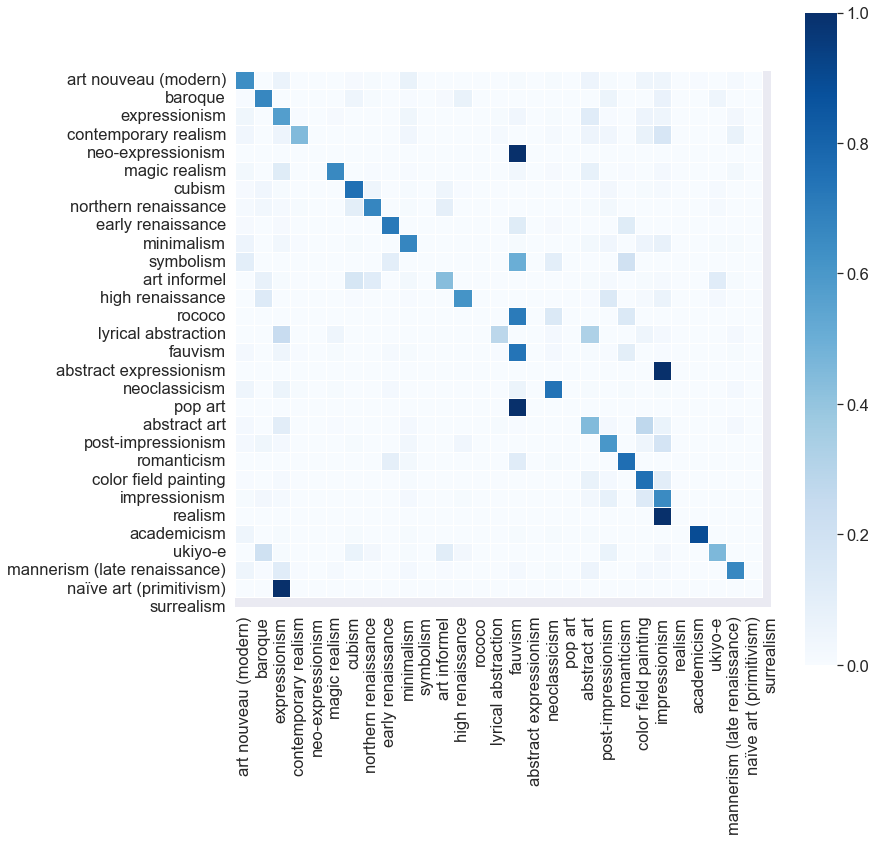

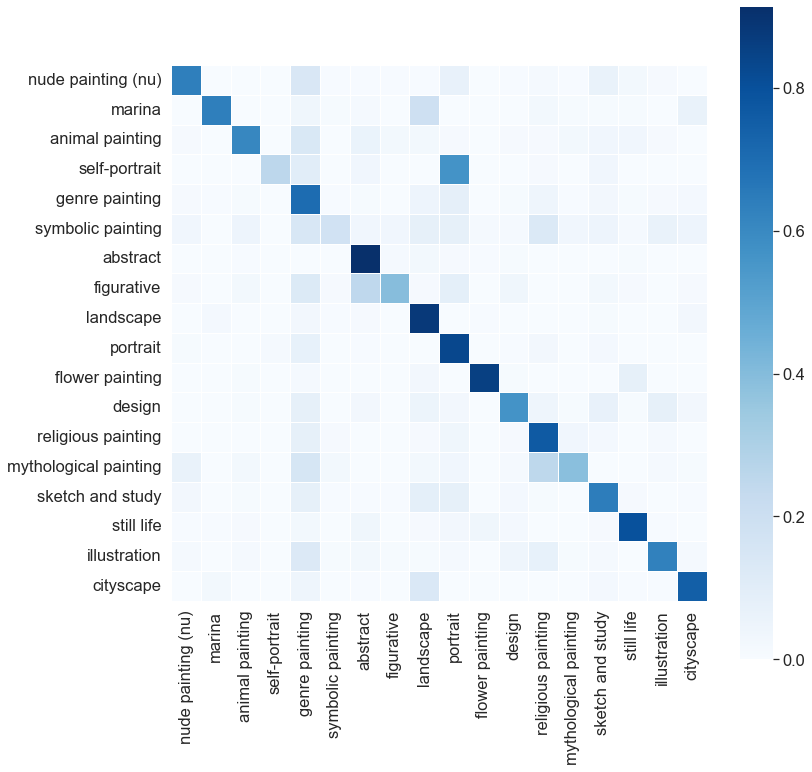

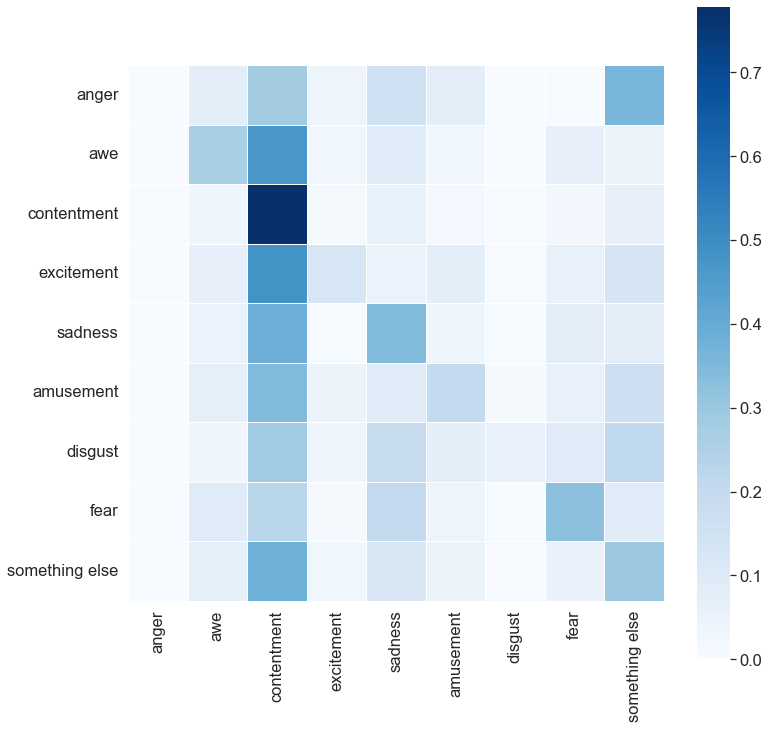

In [17]:
model = torch.load('best_new_multitask_model.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [18]:
results_df

,Top1,Top2,Macro-F1
style,0.641839,0.811341,0.48468
genre,0.756015,0.88659,0.647799
emotion,0.45318,0.639387,0.277208


In [ ]:
results_df.to_csv('results_multi_task_fine_tuning.csv')

Nuovo test, senza encoder pre-trained

In [19]:
model = MultiTaskClassificationModel(data = train, hidden_channels = 128, head_num_layers = 5).to(device)
model

MultiTaskClassificationModel(
  (encoder): GraphModule(
    (convs): ModuleList(
      (0): ModuleDict(
        (artist__belongstofield__field): GATConv((-1, -1), 128, heads=1)
        (artist__belongstomovement__movement): GATConv((-1, -1), 128, heads=1)
        (artist__haspatron__people): GATConv((-1, -1), 128, heads=1)
        (artist__hassubject__subject): GATConv((-1, -1), 128, heads=1)
        (artist__relatedtoschool__training_node): GATConv((-1, -1), 128, heads=1)
        (artist__trainedby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__about__tag): GATConv((-1, -1), 128, heads=1)
        (artwork__createdby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__elicit__emotion): GATConv((-1, -1), 128, heads=1)
        (artwork__hasgenre__genre): GATConv((-1, -1), 128, heads=1)
        (artwork__hasperiod__period): GATConv((-1, -1), 128, heads=1)
        (artwork__hasstyle__style): GATConv((-1, -1), 128, heads=1)
        (artwork__locatedin__city): GATConv((-

In [20]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder(train.x_dict, train.edge_index_dict)

In [21]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_multitask_model.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)

Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:58<00:00,  7.02it/s]


train Loss: 1.8210 Style Acc: 0.3054
            Genre Acc: 0.5318
            Emotion Acc: 0.3781


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.20it/s]


val Loss: 1.5230 Style Acc: 0.3807
            Genre Acc: 0.6455
            Emotion Acc: 0.4139
Validation loss decreased. Saving model...
Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:58<00:00,  7.03it/s]


train Loss: 1.4757 Style Acc: 0.4338
            Genre Acc: 0.6584
            Emotion Acc: 0.4036


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.08it/s]


val Loss: 1.3980 Style Acc: 0.4718
            Genre Acc: 0.6743
            Emotion Acc: 0.4286
Validation loss decreased. Saving model...
Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 1.3990 Style Acc: 0.4716
            Genre Acc: 0.6769
            Emotion Acc: 0.4166


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.21it/s]


val Loss: 1.3530 Style Acc: 0.4989
            Genre Acc: 0.6913
            Emotion Acc: 0.4237
Validation loss decreased. Saving model...
Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.05it/s]


train Loss: 1.3565 Style Acc: 0.4955
            Genre Acc: 0.6859
            Emotion Acc: 0.4206


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.00it/s]


val Loss: 1.3271 Style Acc: 0.5081
            Genre Acc: 0.6972
            Emotion Acc: 0.4383
Validation loss decreased. Saving model...
Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 1.3291 Style Acc: 0.5082
            Genre Acc: 0.6943
            Emotion Acc: 0.4268


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.16it/s]


val Loss: 1.2969 Style Acc: 0.5241
            Genre Acc: 0.7007
            Emotion Acc: 0.4343
Validation loss decreased. Saving model...
Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.11it/s]


train Loss: 1.2995 Style Acc: 0.5239
            Genre Acc: 0.6990
            Emotion Acc: 0.4314


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.03it/s]


val Loss: 1.2998 Style Acc: 0.5245
            Genre Acc: 0.6936
            Emotion Acc: 0.4334
EarlyStopping counter: 1 out of 5
Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.20it/s]


train Loss: 1.2862 Style Acc: 0.5303
            Genre Acc: 0.7045
            Emotion Acc: 0.4322


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.14it/s]


val Loss: 1.2696 Style Acc: 0.5435
            Genre Acc: 0.7091
            Emotion Acc: 0.4435
Validation loss decreased. Saving model...
Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.09it/s]


train Loss: 1.2676 Style Acc: 0.5423
            Genre Acc: 0.7075
            Emotion Acc: 0.4347


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.00it/s]


val Loss: 1.2715 Style Acc: 0.5430
            Genre Acc: 0.7111
            Emotion Acc: 0.4283
EarlyStopping counter: 1 out of 5
Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 1.2520 Style Acc: 0.5496
            Genre Acc: 0.7137
            Emotion Acc: 0.4368


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.10it/s]


val Loss: 1.2510 Style Acc: 0.5528
            Genre Acc: 0.7100
            Emotion Acc: 0.4377
Validation loss decreased. Saving model...
Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.15it/s]


train Loss: 1.2378 Style Acc: 0.5571
            Genre Acc: 0.7159
            Emotion Acc: 0.4387


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.00it/s]


val Loss: 1.2438 Style Acc: 0.5574
            Genre Acc: 0.7119
            Emotion Acc: 0.4355
Validation loss decreased. Saving model...
Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 1.2257 Style Acc: 0.5655
            Genre Acc: 0.7165
            Emotion Acc: 0.4405


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.13it/s]


val Loss: 1.2417 Style Acc: 0.5556
            Genre Acc: 0.7142
            Emotion Acc: 0.4332
Validation loss decreased. Saving model...
Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.09it/s]


train Loss: 1.2121 Style Acc: 0.5708
            Genre Acc: 0.7239
            Emotion Acc: 0.4420


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.05it/s]


val Loss: 1.2406 Style Acc: 0.5570
            Genre Acc: 0.7197
            Emotion Acc: 0.4395
Validation loss decreased. Saving model...
Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 1.2007 Style Acc: 0.5757
            Genre Acc: 0.7257
            Emotion Acc: 0.4442


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  8.95it/s]


val Loss: 1.2246 Style Acc: 0.5738
            Genre Acc: 0.7184
            Emotion Acc: 0.4433
Validation loss decreased. Saving model...
Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.10it/s]


train Loss: 1.1904 Style Acc: 0.5827
            Genre Acc: 0.7287
            Emotion Acc: 0.4443


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.14it/s]


val Loss: 1.2351 Style Acc: 0.5703
            Genre Acc: 0.7172
            Emotion Acc: 0.4418
EarlyStopping counter: 1 out of 5
Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.20it/s]


train Loss: 1.1769 Style Acc: 0.5882
            Genre Acc: 0.7310
            Emotion Acc: 0.4487


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  8.90it/s]


val Loss: 1.2060 Style Acc: 0.5781
            Genre Acc: 0.7264
            Emotion Acc: 0.4430
Validation loss decreased. Saving model...
Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.13it/s]


train Loss: 1.1667 Style Acc: 0.5934
            Genre Acc: 0.7361
            Emotion Acc: 0.4485


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.12it/s]


val Loss: 1.2104 Style Acc: 0.5771
            Genre Acc: 0.7230
            Emotion Acc: 0.4398
EarlyStopping counter: 1 out of 5
Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.16it/s]


train Loss: 1.1581 Style Acc: 0.5987
            Genre Acc: 0.7367
            Emotion Acc: 0.4488


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.08it/s]


val Loss: 1.2082 Style Acc: 0.5821
            Genre Acc: 0.7312
            Emotion Acc: 0.4432
Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 2 out of 5
Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.23it/s]


train Loss: 1.1195 Style Acc: 0.6170
            Genre Acc: 0.7495
            Emotion Acc: 0.4550


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.36it/s]


val Loss: 1.1831 Style Acc: 0.6040
            Genre Acc: 0.7331
            Emotion Acc: 0.4390
Validation loss decreased. Saving model...
Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.33it/s]


train Loss: 1.1081 Style Acc: 0.6231
            Genre Acc: 0.7529
            Emotion Acc: 0.4561


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.31it/s]


val Loss: 1.1797 Style Acc: 0.5988
            Genre Acc: 0.7350
            Emotion Acc: 0.4456
Validation loss decreased. Saving model...
Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.30it/s]


train Loss: 1.1000 Style Acc: 0.6302
            Genre Acc: 0.7560
            Emotion Acc: 0.4571


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.38it/s]


val Loss: 1.1758 Style Acc: 0.6006
            Genre Acc: 0.7350
            Emotion Acc: 0.4435
Validation loss decreased. Saving model...
Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.35it/s]


train Loss: 1.0939 Style Acc: 0.6329
            Genre Acc: 0.7571
            Emotion Acc: 0.4565


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.32it/s]


val Loss: 1.1685 Style Acc: 0.5997
            Genre Acc: 0.7402
            Emotion Acc: 0.4450
Validation loss decreased. Saving model...
Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.28it/s]


train Loss: 1.0864 Style Acc: 0.6343
            Genre Acc: 0.7614
            Emotion Acc: 0.4581


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.37it/s]


val Loss: 1.1682 Style Acc: 0.6026
            Genre Acc: 0.7356
            Emotion Acc: 0.4481
EarlyStopping counter: 1 out of 5
Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.34it/s]


train Loss: 1.0777 Style Acc: 0.6387
            Genre Acc: 0.7599
            Emotion Acc: 0.4591


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


val Loss: 1.1719 Style Acc: 0.6029
            Genre Acc: 0.7316
            Emotion Acc: 0.4445
EarlyStopping counter: 2 out of 5
Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.27it/s]


train Loss: 1.0729 Style Acc: 0.6434
            Genre Acc: 0.7639
            Emotion Acc: 0.4609


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.37it/s]


val Loss: 1.1656 Style Acc: 0.6098
            Genre Acc: 0.7365
            Emotion Acc: 0.4449
Validation loss decreased. Saving model...
Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.30it/s]


train Loss: 1.0666 Style Acc: 0.6450
            Genre Acc: 0.7670
            Emotion Acc: 0.4614


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.23it/s]


val Loss: 1.1627 Style Acc: 0.6075
            Genre Acc: 0.7374
            Emotion Acc: 0.4465
Validation loss decreased. Saving model...
Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.30it/s]


train Loss: 1.0582 Style Acc: 0.6503
            Genre Acc: 0.7684
            Emotion Acc: 0.4630


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.32it/s]


val Loss: 1.1639 Style Acc: 0.6112
            Genre Acc: 0.7345
            Emotion Acc: 0.4426
EarlyStopping counter: 1 out of 5
Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.31it/s]


train Loss: 1.0507 Style Acc: 0.6538
            Genre Acc: 0.7708
            Emotion Acc: 0.4645


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.18it/s]


val Loss: 1.1579 Style Acc: 0.6155
            Genre Acc: 0.7376
            Emotion Acc: 0.4419
Validation loss decreased. Saving model...
Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.35it/s]


train Loss: 1.0436 Style Acc: 0.6562
            Genre Acc: 0.7726
            Emotion Acc: 0.4628


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.44it/s]


val Loss: 1.1674 Style Acc: 0.6111
            Genre Acc: 0.7312
            Emotion Acc: 0.4419
EarlyStopping counter: 1 out of 5
Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.40it/s]


train Loss: 1.0365 Style Acc: 0.6613
            Genre Acc: 0.7743
            Emotion Acc: 0.4640


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.34it/s]


val Loss: 1.1639 Style Acc: 0.6089
            Genre Acc: 0.7335
            Emotion Acc: 0.4436
Epoch 00029: reducing learning rate of group 0 to 2.5000e-05.
EarlyStopping counter: 2 out of 5
Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.37it/s]


train Loss: 1.0150 Style Acc: 0.6740
            Genre Acc: 0.7828
            Emotion Acc: 0.4702


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.38it/s]


val Loss: 1.1520 Style Acc: 0.6160
            Genre Acc: 0.7402
            Emotion Acc: 0.4441
Validation loss decreased. Saving model...
Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.38it/s]


train Loss: 1.0083 Style Acc: 0.6766
            Genre Acc: 0.7821
            Emotion Acc: 0.4713


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.37it/s]


val Loss: 1.1538 Style Acc: 0.6181
            Genre Acc: 0.7371
            Emotion Acc: 0.4452
EarlyStopping counter: 1 out of 5
Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.22it/s]


train Loss: 1.0041 Style Acc: 0.6776
            Genre Acc: 0.7833
            Emotion Acc: 0.4707


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.06it/s]


val Loss: 1.1517 Style Acc: 0.6170
            Genre Acc: 0.7390
            Emotion Acc: 0.4455
EarlyStopping counter: 2 out of 5
Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [01:01<00:00,  6.60it/s]


train Loss: 0.9971 Style Acc: 0.6808
            Genre Acc: 0.7876
            Emotion Acc: 0.4717


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  8.10it/s]


val Loss: 1.1512 Style Acc: 0.6218
            Genre Acc: 0.7377
            Emotion Acc: 0.4462
EarlyStopping counter: 3 out of 5
Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.09it/s]


train Loss: 0.9940 Style Acc: 0.6832
            Genre Acc: 0.7856
            Emotion Acc: 0.4728


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.14it/s]


val Loss: 1.1483 Style Acc: 0.6207
            Genre Acc: 0.7403
            Emotion Acc: 0.4453
Validation loss decreased. Saving model...
Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.25it/s]


train Loss: 0.9902 Style Acc: 0.6855
            Genre Acc: 0.7879
            Emotion Acc: 0.4730


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.17it/s]


val Loss: 1.1498 Style Acc: 0.6161
            Genre Acc: 0.7425
            Emotion Acc: 0.4470
EarlyStopping counter: 1 out of 5
Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 0.9854 Style Acc: 0.6868
            Genre Acc: 0.7895
            Emotion Acc: 0.4729


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.03it/s]


val Loss: 1.1494 Style Acc: 0.6216
            Genre Acc: 0.7411
            Emotion Acc: 0.4447
Epoch 00036: reducing learning rate of group 0 to 1.2500e-05.
EarlyStopping counter: 2 out of 5
Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.17it/s]


train Loss: 0.9729 Style Acc: 0.6927
            Genre Acc: 0.7957
            Emotion Acc: 0.4749


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.01it/s]


val Loss: 1.1454 Style Acc: 0.6227
            Genre Acc: 0.7381
            Emotion Acc: 0.4439
Validation loss decreased. Saving model...
Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.16it/s]


train Loss: 0.9695 Style Acc: 0.6963
            Genre Acc: 0.7963
            Emotion Acc: 0.4751


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.13it/s]


val Loss: 1.1478 Style Acc: 0.6244
            Genre Acc: 0.7426
            Emotion Acc: 0.4452
EarlyStopping counter: 1 out of 5
Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.18it/s]


train Loss: 0.9656 Style Acc: 0.6964
            Genre Acc: 0.7978
            Emotion Acc: 0.4743


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.05it/s]


val Loss: 1.1483 Style Acc: 0.6238
            Genre Acc: 0.7400
            Emotion Acc: 0.4441
Epoch 00039: reducing learning rate of group 0 to 6.2500e-06.
EarlyStopping counter: 2 out of 5
Epoch 40/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.17it/s]


train Loss: 0.9621 Style Acc: 0.6999
            Genre Acc: 0.7975
            Emotion Acc: 0.4767


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.07it/s]


val Loss: 1.1450 Style Acc: 0.6224
            Genre Acc: 0.7431
            Emotion Acc: 0.4467
EarlyStopping counter: 3 out of 5
Epoch 41/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.19it/s]


train Loss: 0.9573 Style Acc: 0.7017
            Genre Acc: 0.7969
            Emotion Acc: 0.4798


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.10it/s]


val Loss: 1.1456 Style Acc: 0.6242
            Genre Acc: 0.7416
            Emotion Acc: 0.4442
EarlyStopping counter: 4 out of 5
Epoch 42/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.18it/s]


train Loss: 0.9555 Style Acc: 0.7021
            Genre Acc: 0.8001
            Emotion Acc: 0.4793


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.15it/s]

val Loss: 1.1461 Style Acc: 0.6242
            Genre Acc: 0.7408
            Emotion Acc: 0.4462
Epoch 00042: reducing learning rate of group 0 to 3.1250e-06.
EarlyStopping counter: 5 out of 5
Best epoch: 0040
Best loss: 1.1450


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.72it/s]


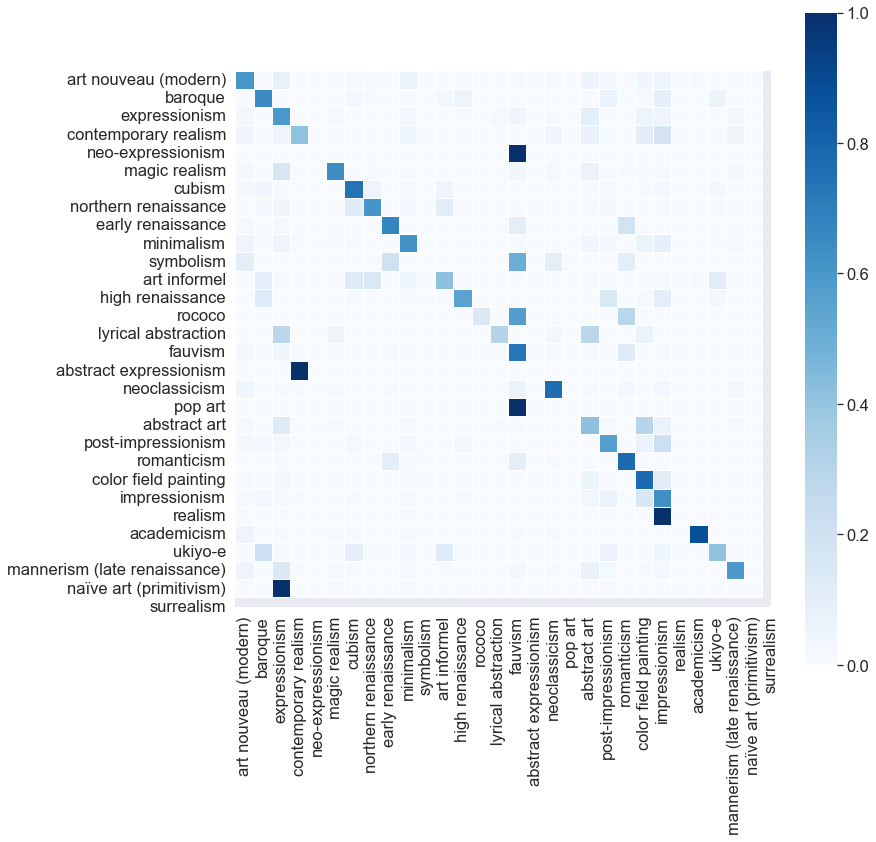

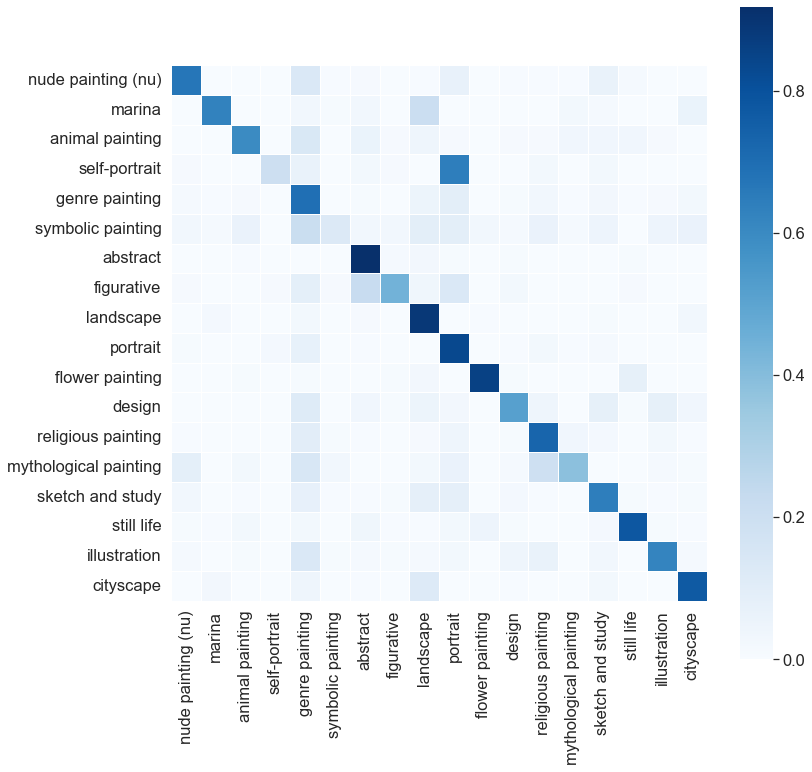

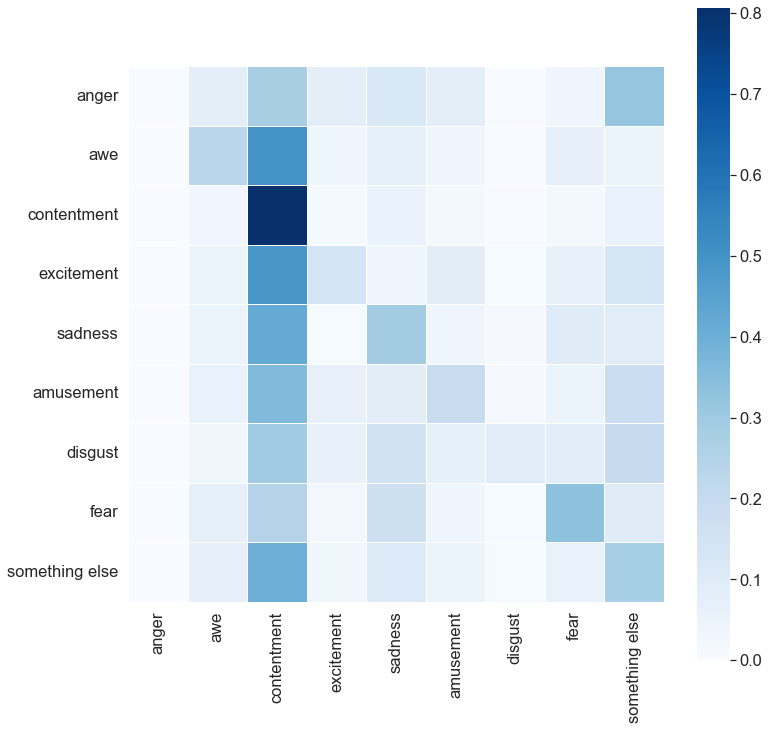

In [22]:
model = torch.load('best_multitask_model.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [23]:
results_df

,Top1,Top2,Macro-F1
style,0.6259,0.803831,0.479201
genre,0.752644,0.88751,0.640365
emotion,0.453333,0.639847,0.276734


In [24]:
results_df.to_csv('resuls_multi_task_scratch.csv')